In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Read the training data

In [5]:
train_data=pd.read_csv("training.csv")

In [6]:
predictors=train_data.drop(["class"],axis=1)
target=train_data["class"]

# Read the test data

In [7]:
test_data=pd.read_csv("testing.csv")

In [8]:
predictors_test=test_data.drop(["class"],axis=1)
target_test=test_data["class"]

In [59]:
class_names=target_test.unique()

# Base Model

In [9]:
# Base model with no hyperparameter tuning
from sklearn import metrics
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(predictors, target)
predictions = base_model.predict(predictors_test)
print("Accuracy is:",metrics.accuracy_score(target_test,predictions))

Accuracy is: 0.777120315582


### Feature Ranking

In [10]:
for feature in zip(predictors, base_model.feature_importances_):
    print(feature)

('BrdIndx', 0.0034763253070681926)
('Area', 0.022952227924512212)
('Round', 0.00068588225687923584)
('Bright', 0.0033281674902774921)
('Compact', 0.0024398176614593087)
('ShpIndx', 0.0012977554128318883)
('Mean_G', 0.0072705552785245434)
('Mean_R', 0.01165299713109697)
('Mean_NIR', 0.013640597070248464)
('SD_G', 0.0)
('SD_R', 0.0089419580597286073)
('SD_NIR', 0.0093915144981367594)
('LW', 0.0034702813078158075)
('GLCM1', 0.0023327718079373888)
('Rect', 0.0055648286281536202)
('GLCM2', 0.00028986290024935363)
('Dens', 0.0)
('Assym', 0.0)
('NDVI', 0.068453899977002269)
('BordLngth', 0.020391884341218434)
('GLCM3', 0.016793353221218187)
('BrdIndx_40', 0.0012703556671797786)
('Area_40', 0.0023226047165465784)
('Round_40', 0.0082555377408677182)
('Bright_40', 0.027750190251379581)
('Compact_40', 0.0010133504905903167)
('ShpIndx_40', 0.0020576467706377075)
('Mean_G_40', 0.0012563957147931867)
('Mean_R_40', 0.028011910425691289)
('Mean_NIR_40', 0.0058598093586309623)
('SD_G_40', 0.00203932993

#### Feature selection at 0.005 threshold

In [14]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(base_model,threshold=0.005)

# Train the selector
sfm.fit(predictors, target)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.005)

In [15]:
sfm.get_params

<bound method BaseEstimator.get_params of SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.005)>

In [16]:
sfm.get_support(indices=True)

array([  1,   6,   7,   8,  10,  11,  14,  18,  19,  20,  23,  24,  28,
        29,  33,  37,  39,  42,  43,  45,  47,  49,  50,  54,  60,  62,
        66,  69,  70,  71,  72,  76,  79,  81,  86,  87,  89,  90,  91,
        92,  94, 102, 105, 108, 112, 113, 116, 123, 124, 126, 131, 133,
       135, 137, 141, 142, 143, 144], dtype=int64)

In [17]:
a=[]
for feature_list_index in sfm.get_support(indices=True):
    a.append(feature_list_index)

print(len(a))

58


#### Retaining only the important features

In [18]:
X_important_train = sfm.transform(predictors)
X_important_test = sfm.transform(predictors_test)

## Hyperparameter Tuning

In [19]:
#Default hyperparameters for random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [21]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_important_train,target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [22]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1200}

In [23]:
best_random = rf_random.best_estimator_
predictions = best_random.predict(X_important_test)
print("Accuracy is:",metrics.accuracy_score(target_test,predictions))

Accuracy is: 0.792899408284


In [24]:
from sklearn.metrics import classification_report
print(classification_report(target_test, predictions, target_names=target_test.unique()))

             precision    recall  f1-score   support

  concrete        0.92      0.78      0.84        45
    shadow        0.90      0.64      0.75        97
      tree        0.65      0.95      0.77        21
   asphalt        0.75      0.88      0.81        93
  building        0.75      0.88      0.81        83
     grass        1.00      0.93      0.96        14
      pool        0.77      0.91      0.84        45
       car        0.56      0.70      0.62        20
      soil        0.87      0.70      0.78        89

avg / total       0.81      0.79      0.79       507



In [48]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[35  0  2  1  0  0  6  1  0]
 [ 1 62  4 25  0  0  1  4  0]
 [ 0  0 20  1  0  0  0  0  0]
 [ 0  4  2 82  0  0  0  4  1]
 [ 0  1  1  0 73  0  0  2  6]
 [ 0  0  0  0  1 13  0  0  0]
 [ 2  0  0  0  0  0 41  0  2]
 [ 0  2  2  1  1  0  0 14  0]
 [ 0  0  0  0 22  0  5  0 62]]


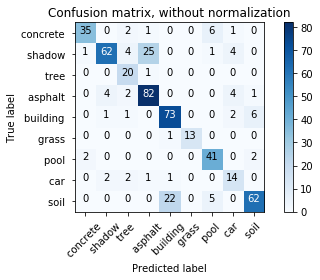

In [60]:
c=confusion_matrix(target_test, predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(c, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

#### Feature selection at 0.01 threshold

In [61]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(base_model, threshold=0.01)

# Train the selector
sfm.fit(predictors, target)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.01)

In [62]:
a=[]
for feature_list_index in sfm.get_support(indices=True):
    a.append(feature_list_index)

print(len(a))

35


#### Retaining only the important features

In [63]:
X_important_train_1 = sfm.transform(predictors)
X_important_test_1 = sfm.transform(predictors_test)

In [64]:
from sklearn.model_selection import RandomizedSearchCV
rf_random_1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_1.fit(X_important_train_1,target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [65]:
rf_random_1.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [66]:
best_random_1 = rf_random_1.best_estimator_
predictions = best_random_1.predict(X_important_test_1)
print("Accuracy is:",metrics.accuracy_score(target_test,predictions))

Accuracy is: 0.786982248521


In [67]:
print(classification_report(target_test, predictions, target_names=target_test.unique()))

             precision    recall  f1-score   support

  concrete        0.89      0.76      0.82        45
    shadow        0.89      0.67      0.76        97
      tree        0.59      0.95      0.73        21
   asphalt        0.77      0.87      0.82        93
  building        0.73      0.89      0.80        83
     grass        1.00      0.93      0.96        14
      pool        0.75      0.89      0.82        45
       car        0.54      0.65      0.59        20
      soil        0.89      0.66      0.76        89

avg / total       0.81      0.79      0.79       507



Confusion matrix, without normalization
[[34  1  2  0  0  0  7  1  0]
 [ 1 65  4 22  0  0  1  4  0]
 [ 0  0 20  1  0  0  0  0  0]
 [ 0  5  3 81  0  0  0  3  1]
 [ 0  1  1  0 74  0  0  3  4]
 [ 0  0  0  0  1 13  0  0  0]
 [ 3  0  0  0  0  0 40  0  2]
 [ 0  1  4  1  1  0  0 13  0]
 [ 0  0  0  0 25  0  5  0 59]]


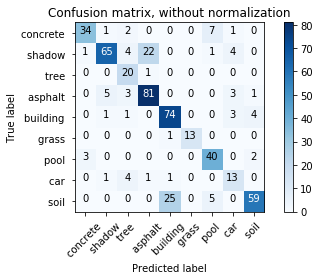

In [68]:
c=confusion_matrix(target_test, predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(c, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

## On the entire featureset

In [69]:
from sklearn.model_selection import RandomizedSearchCV
rf_random_2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_2.fit(predictors,target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [70]:
rf_random_2.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [71]:
# On 145 features
best_random_2 = rf_random_2.best_estimator_
predictions = best_random_2.predict(predictors_test)
print("Accuracy is:",metrics.accuracy_score(target_test,predictions))

Accuracy is: 0.812623274162


In [72]:
print(classification_report(target_test, predictions, target_names=target_test.unique()))

             precision    recall  f1-score   support

  concrete        0.95      0.82      0.88        45
    shadow        0.88      0.72      0.79        97
      tree        0.67      0.95      0.78        21
   asphalt        0.79      0.89      0.84        93
  building        0.76      0.88      0.82        83
     grass        1.00      0.86      0.92        14
      pool        0.79      0.93      0.86        45
       car        0.58      0.55      0.56        20
      soil        0.88      0.72      0.79        89

avg / total       0.82      0.81      0.81       507



Confusion matrix, without normalization
[[37  1  1  0  0  0  4  1  1]
 [ 1 70  3 20  0  0  1  2  0]
 [ 0  0 20  1  0  0  0  0  0]
 [ 0  4  2 83  0  0  0  3  1]
 [ 0  1  1  0 73  0  0  2  6]
 [ 0  1  0  0  1 12  0  0  0]
 [ 1  0  1  0  0  0 42  0  1]
 [ 0  3  2  1  3  0  0 11  0]
 [ 0  0  0  0 19  0  6  0 64]]


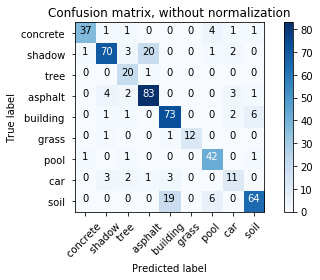

In [73]:
c=confusion_matrix(target_test, predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(c, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

In [74]:
import matplotlib.pyplot as plt
importances = best_random_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_random_2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices=indices[0:20]
# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 18 (0.046050)
2. feature 39 (0.035563)
3. feature 60 (0.032472)
4. feature 81 (0.028617)
5. feature 6 (0.020592)
6. feature 144 (0.018461)
7. feature 66 (0.018011)
8. feature 87 (0.017995)
9. feature 29 (0.017954)
10. feature 102 (0.017137)
11. feature 123 (0.016762)
12. feature 3 (0.016473)
13. feature 7 (0.016301)
14. feature 48 (0.015826)
15. feature 70 (0.015683)
16. feature 71 (0.015103)
17. feature 28 (0.014835)
18. feature 27 (0.014464)
19. feature 8 (0.014237)
20. feature 92 (0.013698)


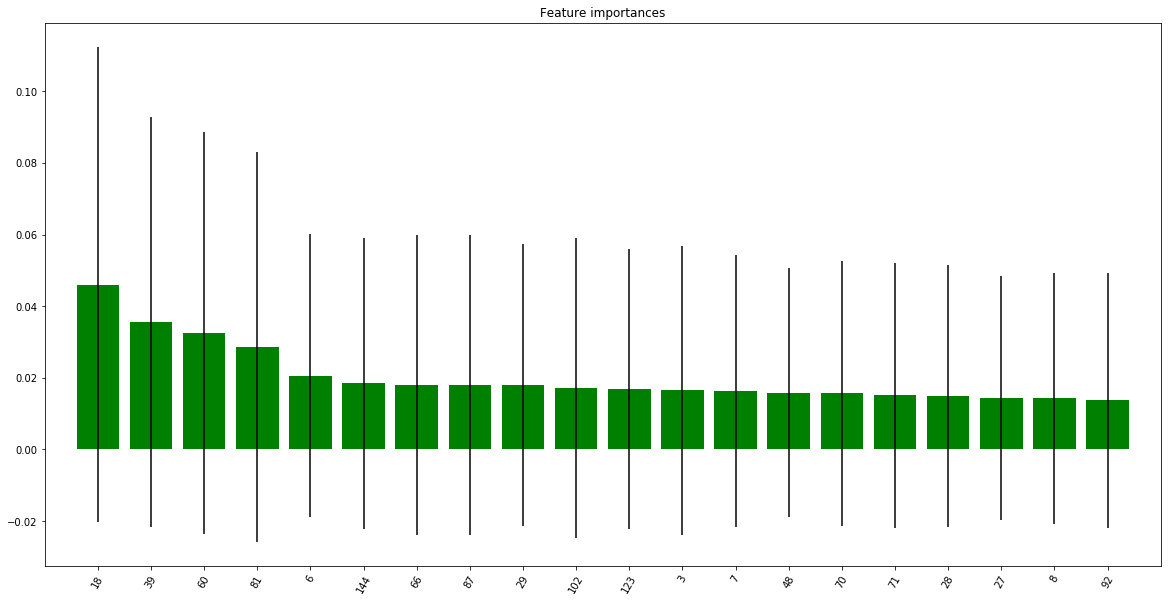

In [75]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(20), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(20), indices,rotation=60)
plt.xlim([-1, 20])
plt.show()

# Using RFE with SVC

Optimal number of features : 20


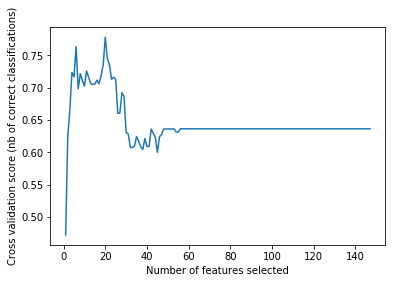

In [76]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=10,
              scoring='accuracy')
rfecv.fit(predictors, target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [77]:
print('Chosen best feature by rfe with 10-fold cross-validation is :',predictors.columns[rfecv.support_])

Chosen best feature by rfe with 10-fold cross-validation is : Index(['Bright', 'Mean_G', 'Mean_R', 'Mean_NIR', 'Mean_G_40', 'Mean_R_40',
       'Mean_NIR_40', 'Mean_G_60', 'Mean_R_60', 'Mean_NIR_60', 'Mean_R_80',
       'Mean_NIR_80', 'Mean_G_100', 'Mean_R_100', 'Mean_NIR_100', 'Bright_120',
       'Mean_R_120', 'Bright_140', 'Mean_G_140', 'Mean_R_140'],
      dtype='object')


In [78]:
predict_svc=rfecv.predict(predictors_test)

In [79]:
print("Accuracy:",metrics.accuracy_score(target_test,predict_svc))

Accuracy: 0.648915187377


In [80]:
print(classification_report(target_test, predict_svc, target_names=target_test.unique()))

             precision    recall  f1-score   support

  concrete        0.88      0.82      0.85        45
    shadow        0.57      0.60      0.58        97
      tree        0.49      0.86      0.62        21
   asphalt        0.65      0.52      0.57        93
  building        0.61      0.80      0.69        83
     grass        1.00      0.93      0.96        14
      pool        0.74      0.96      0.83        45
       car        0.44      0.55      0.49        20
      soil        0.73      0.39      0.51        89

avg / total       0.66      0.65      0.64       507



Confusion matrix, without normalization
[[37  3  2  0  0  0  3  0  0]
 [ 2 58  3 24  0  0  0  9  1]
 [ 0  3 18  0  0  0  0  0  0]
 [ 0 34  7 48  1  0  0  2  1]
 [ 1  1  1  2 66  0  1  3  8]
 [ 0  0  0  0  1 13  0  0  0]
 [ 1  1  0  0  0  0 43  0  0]
 [ 0  2  3  0  1  0  0 11  3]
 [ 1  0  3  0 39  0 11  0 35]]


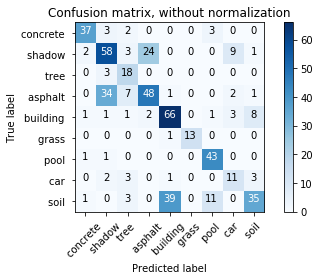

In [81]:
c=confusion_matrix(target_test, predict_svc)
np.set_printoptions(precision=2)
plot_confusion_matrix(c, classes=class_names,title='Confusion matrix, without normalization')
plt.show()